✅ 한글 폰트 설정: AppleGothic
🚀 서울시 범죄 예측 모델 - Feature Engineering & ML 학습

📊 [Step 1] 기초 데이터 생성
--------------------------------------------------------------------------------
✅ df_time_final: (5, 9) - 5대 범죄 × 8개 시간대
✅ df_place_final: (5, 5) - 5대 범죄 × 4개 장소
✅ df_crime_yearly: (1250, 4) - 25개 자치구 × 10년 × 5대 범죄

📊 [Step 2] 확률 분포 계산
--------------------------------------------------------------------------------
✅ 범죄유형별 시간대 발생 확률 계산 완료
✅ 범죄유형별 장소 발생 확률 계산 완료
✅ 범죄유형별 자치구 발생 확률 계산 완료

📊 [Step 3] 상황별 시뮬레이션 데이터셋 생성
--------------------------------------------------------------------------------
   총 조합 수: 4,000개
   (25 자치구 × 5 범죄유형 × 4 장소 × 8 시간대)
   ⏳ 개별 확률 계산 중...
   ✅ 개별 확률 계산 완료

   ⏳ risk_score2 계산 중...

✅ risk_score2 + Scaling 완료!
   원본 범위: [305.75, 3412.32]
   스케일 후 (risk_score): [0.00, 100.00]

✅ 시뮬레이션 데이터셋 생성 완료: (4000, 9)
   컬럼: ['자치구', '범죄유형', '장소카테고리', '시간대', 'p_district', 'p_place', 'p_time', 'risk_score2', 'risk_score']

📊 [Step 4] 타겟 변수 생성
------------------------------------------

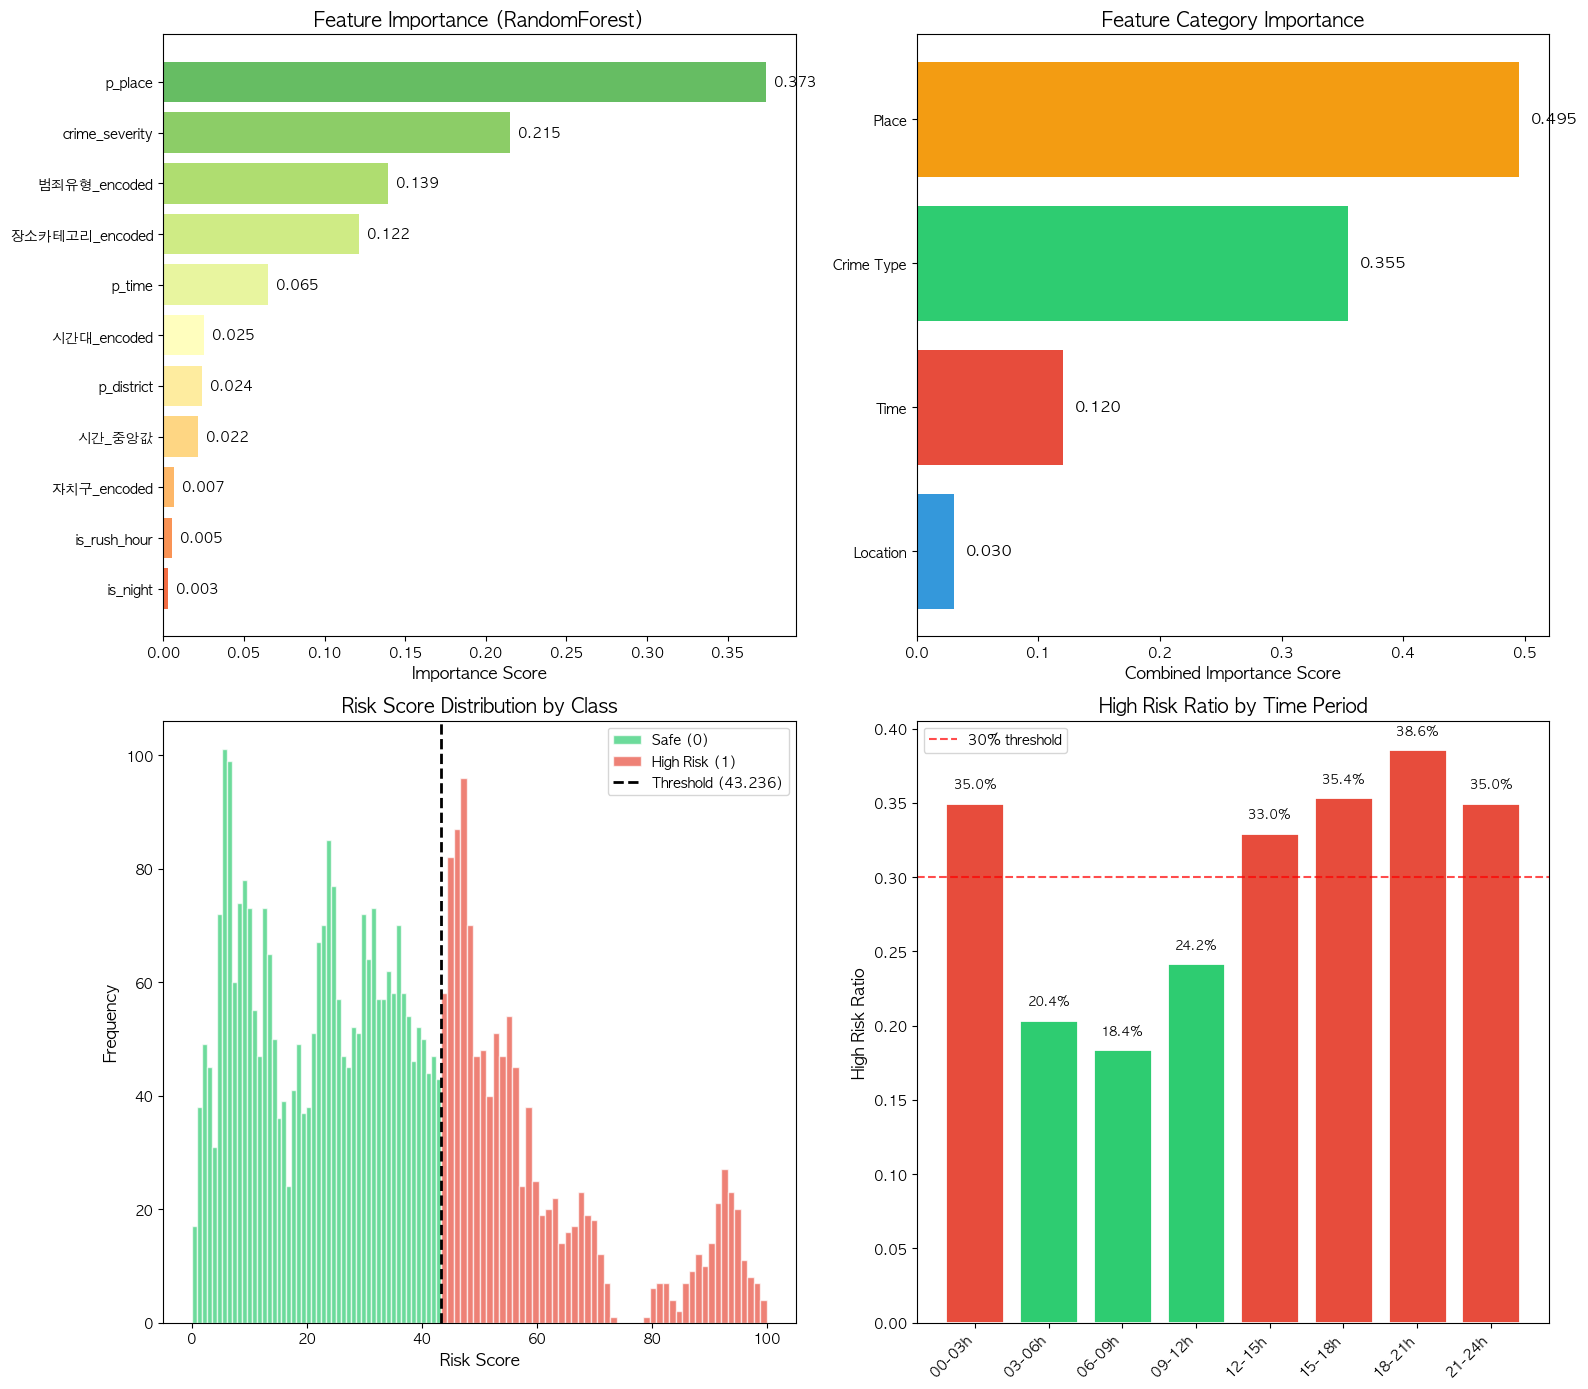

In [2]:
# ============================================================================
# 서울시 범죄 예측 모델 - Feature Engineering & Machine Learning
# Step 3: 학습 데이터셋 구축 및 베이스라인 모델 학습
# ============================================================================

import pandas as pd
import numpy as np
from itertools import product
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

def set_korean_font():
    """시스템에서 사용 가능한 한글 폰트 자동 감지 및 설정"""
    
    # 폰트 우선순위 리스트 (macOS → Linux → Windows)
    font_candidates = [
        'AppleGothic',           # macOS 기본
        'Apple SD Gothic Neo',   # macOS
        'NanumGothic',          # 나눔고딕
        'NanumBarunGothic',     # 나눔바른고딕
        'Malgun Gothic',        # 맑은 고딕 (Windows)
        'Noto Sans CJK KR',     # 구글 Noto
        'DejaVu Sans'           # 폴백 (한글 안되지만 깨지지는 않음)
    ]
    
    # 시스템에 설치된 폰트 목록
    available_fonts = [f.name for f in fm.fontManager.ttflist]
    
    # 사용 가능한 첫 번째 폰트 찾기
    selected_font = None
    for font in font_candidates:
        if font in available_fonts:
            selected_font = font
            break
    
    # 폰트 설정
    if selected_font:
        plt.rc('font', family=selected_font)
        print(f"✅ 한글 폰트 설정: {selected_font}")
    else:
        # 폰트를 찾지 못한 경우 - 유니코드 사용
        plt.rcParams['axes.unicode_minus'] = False
        print("⚠️ 한글 폰트를 찾지 못했습니다. 기본 설정을 사용합니다.")
        print("   한글이 깨질 수 있습니다. 나눔고딕 설치를 권장합니다.")
    
    # 마이너스 기호 깨짐 방지
    plt.rcParams['axes.unicode_minus'] = False
    
    return selected_font

# 한글 폰트 설정
selected_font = set_korean_font()



print("=" * 80)
print("🚀 서울시 범죄 예측 모델 - Feature Engineering & ML 학습")
print("=" * 80)

# ============================================================================
# 1. 데이터 생성 (이전 단계 데이터 기반 샘플)
# ============================================================================

print("\n📊 [Step 1] 기초 데이터 생성")
print("-" * 80)

# 1-1. 시간대 분포 데이터 (df_time_final)
time_data = {
    '범죄분류': ['살인', '강도', '성폭력', '절도', '폭력'],
    '00시-03시': [89, 127, 5765, 15234, 25678],
    '03시-06시': [67, 98, 3456, 8765, 12345],
    '06시-09시': [45, 65, 2345, 12456, 18765],
    '09시-12시': [78, 89, 4567, 25678, 34567],
    '12시-15시': [92, 112, 5678, 32456, 45678],
    '15시-18시': [98, 134, 6234, 38765, 52345],
    '18시-21시': [112, 156, 7890, 42345, 58765],
    '21시-24시': [95, 143, 6543, 28765, 42345]
}
df_time_final = pd.DataFrame(time_data)

# 1-2. 장소 분포 데이터 (df_place_final)
place_data = {
    '범죄분류': ['살인', '강도', '성폭력', '절도', '폭력'],
    '주거지구': [312, 234, 18765, 45678, 98765],
    '업무지구': [89, 145, 8765, 32456, 54321],
    '다중이용시설': [156, 387, 15432, 98765, 156789],
    '기타': [119, 158, 5516, 27565, 45555]
}
df_place_final = pd.DataFrame(place_data)

# 1-3. 자치구별 연도별 통계 (df_crime_yearly)
districts = ['강남구', '강동구', '강북구', '강서구', '관악구', 
             '광진구', '구로구', '금천구', '노원구', '도봉구',
             '동대문구', '동작구', '마포구', '서대문구', '서초구',
             '성동구', '성북구', '송파구', '양천구', '영등포구',
             '용산구', '은평구', '종로구', '중구', '중랑구']

years = list(range(2014, 2024))
crime_types = ['살인', '강도', '성폭력', '절도', '폭력']

# 자치구별 범죄 발생 특성 (기준값)
district_crime_base = {
    '강남구': {'살인': 15, '강도': 45, '성폭력': 850, '절도': 4500, '폭력': 6800},
    '강동구': {'살인': 12, '강도': 35, '성폭력': 650, '절도': 3200, '폭력': 5200},
    '강북구': {'살인': 18, '강도': 42, '성폭력': 720, '절도': 2800, '폭력': 5800},
    '강서구': {'살인': 14, '강도': 38, '성폭력': 780, '절도': 3800, '폭력': 6200},
    '관악구': {'살인': 16, '강도': 48, '성폭력': 920, '절도': 4200, '폭력': 7200},
    '광진구': {'살인': 11, '강도': 32, '성폭력': 680, '절도': 3400, '폭력': 5400},
    '구로구': {'살인': 13, '강도': 40, '성폭력': 750, '절도': 3600, '폭력': 5900},
    '금천구': {'살인': 10, '강도': 28, '성폭력': 580, '절도': 2600, '폭력': 4200},
    '노원구': {'살인': 15, '강도': 36, '성폭력': 720, '절도': 3400, '폭력': 5600},
    '도봉구': {'살인': 9, '강도': 24, '성폭력': 480, '절도': 2200, '폭력': 3800},
    '동대문구': {'살인': 14, '강도': 42, '성폭력': 780, '절도': 3800, '폭력': 6000},
    '동작구': {'살인': 11, '강도': 30, '성폭력': 620, '절도': 2800, '폭력': 4600},
    '마포구': {'살인': 13, '강도': 44, '성폭력': 820, '절도': 4000, '폭력': 6400},
    '서대문구': {'살인': 10, '강도': 28, '성폭력': 560, '절도': 2600, '폭력': 4400},
    '서초구': {'살인': 12, '강도': 38, '성폭력': 720, '절도': 3800, '폭력': 5600},
    '성동구': {'살인': 10, '강도': 26, '성폭력': 540, '절도': 2600, '폭력': 4200},
    '성북구': {'살인': 14, '강도': 36, '성폭력': 680, '절도': 3200, '폭력': 5400},
    '송파구': {'살인': 16, '강도': 46, '성폭력': 880, '절도': 4400, '폭력': 6800},
    '양천구': {'살인': 11, '강도': 30, '성폭력': 600, '절도': 2800, '폭력': 4600},
    '영등포구': {'살인': 18, '강도': 52, '성폭력': 980, '절도': 4800, '폭력': 7600},
    '용산구': {'살인': 12, '강도': 36, '성폭력': 680, '절도': 3400, '폭력': 5200},
    '은평구': {'살인': 13, '강도': 32, '성폭력': 640, '절도': 3000, '폭력': 5000},
    '종로구': {'살인': 14, '강도': 48, '성폭력': 860, '절도': 4200, '폭력': 6200},
    '중구': {'살인': 15, '강도': 50, '성폭력': 900, '절도': 4600, '폭력': 6600},
    '중랑구': {'살인': 16, '강도': 44, '성폭력': 760, '절도': 3400, '폭력': 5800}
}

# 연도별 트렌드 (감소 추세)
yearly_trend = {
    2014: 1.15, 2015: 1.12, 2016: 1.08, 2017: 1.05, 2018: 1.02,
    2019: 1.00, 2020: 0.92, 2021: 0.88, 2022: 0.90, 2023: 0.93
}

# 데이터 생성
yearly_records = []
np.random.seed(42)

for district in districts:
    for year in years:
        for crime in crime_types:
            base = district_crime_base[district][crime]
            trend = yearly_trend[year]
            noise = np.random.normal(1, 0.1)
            count = int(base * trend * noise)
            yearly_records.append({
                '자치구': district,
                '연도': year,
                '범죄유형': crime,
                '발생건수': max(0, count)
            })

df_crime_yearly = pd.DataFrame(yearly_records)

print(f"✅ df_time_final: {df_time_final.shape} - 5대 범죄 × 8개 시간대")
print(f"✅ df_place_final: {df_place_final.shape} - 5대 범죄 × 4개 장소")
print(f"✅ df_crime_yearly: {df_crime_yearly.shape} - 25개 자치구 × 10년 × 5대 범죄")

# ============================================================================
# 2. 확률 분포 계산
# ============================================================================

print("\n📊 [Step 2] 확률 분포 계산")
print("-" * 80)

# 2-1. 시간대별 발생 비율 계산
time_cols = [col for col in df_time_final.columns if col != '범죄분류']
df_time_prob = df_time_final.copy()

for col in time_cols:
    df_time_prob[f'{col}_비율'] = df_time_prob[col] / df_time_prob[time_cols].sum(axis=1)

time_prob_dict = {}
for _, row in df_time_prob.iterrows():
    crime = row['범죄분류']
    time_prob_dict[crime] = {}
    for col in time_cols:
        time_prob_dict[crime][col] = row[f'{col}_비율']

print("✅ 범죄유형별 시간대 발생 확률 계산 완료")

# 2-2. 장소별 발생 비율 계산
place_cols = [col for col in df_place_final.columns if col != '범죄분류']
df_place_prob = df_place_final.copy()

for col in place_cols:
    df_place_prob[f'{col}_비율'] = df_place_prob[col] / df_place_prob[place_cols].sum(axis=1)

place_prob_dict = {}
for _, row in df_place_prob.iterrows():
    crime = row['범죄분류']
    place_prob_dict[crime] = {}
    for col in place_cols:
        place_prob_dict[crime][col] = row[f'{col}_비율']

print("✅ 범죄유형별 장소 발생 확률 계산 완료")

# 2-3. 자치구별 발생 비율 계산
district_crime_totals = df_crime_yearly.groupby(['자치구', '범죄유형'])['발생건수'].sum().reset_index()
crime_totals = district_crime_totals.groupby('범죄유형')['발생건수'].sum()

district_prob_dict = {}
for crime in crime_types:
    district_prob_dict[crime] = {}
    crime_data = district_crime_totals[district_crime_totals['범죄유형'] == crime]
    total = crime_totals[crime]
    for _, row in crime_data.iterrows():
        district_prob_dict[crime][row['자치구']] = row['발생건수'] / total

print("✅ 범죄유형별 자치구 발생 확률 계산 완료")

# ============================================================================
# 3. 시뮬레이션 데이터셋 생성 (모든 조합)
# ============================================================================

print("\n📊 [Step 3] 상황별 시뮬레이션 데이터셋 생성")
print("-" * 80)

# 모든 조합 생성
combinations = list(product(districts, crime_types, place_cols, time_cols))
print(f"   총 조합 수: {len(combinations):,}개")
print(f"   (25 자치구 × 5 범죄유형 × 4 장소 × 8 시간대)")

# 데이터프레임 생성
df_combinations = pd.DataFrame(combinations, 
                               columns=['자치구', '범죄유형', '장소카테고리', '시간대'])

# ============================================================================
# 개별 확률 계산 및 저장 (먼저!)
# ============================================================================

print("   ⏳ 개별 확률 계산 중...")

# 각 확률을 별도 컬럼으로 저장
df_combinations['p_district'] = df_combinations.apply(
    lambda x: district_prob_dict.get(x['범죄유형'], {}).get(x['자치구'], 0.04), axis=1)
df_combinations['p_place'] = df_combinations.apply(
    lambda x: place_prob_dict.get(x['범죄유형'], {}).get(x['장소카테고리'], 0.25), axis=1)
df_combinations['p_time'] = df_combinations.apply(
    lambda x: time_prob_dict.get(x['범죄유형'], {}).get(x['시간대'], 0.125), axis=1)

print("   ✅ 개별 확률 계산 완료")

# ============================================================================
# risk_score2 계산 및 스케일링
# ============================================================================

from sklearn.preprocessing import MinMaxScaler

def calculate_risk_score_v2(row):
    """덧셈 기반 위험 점수 계산"""
    crime = row['범죄유형']
    
    # 이미 계산된 확률 사용
    p_district = row['p_district']
    p_place = row['p_place']
    p_time = row['p_time']
    
    crime_weight = {
        '살인': 5.0, '강도': 4.0, '성폭력': 3.5, '폭력': 2.0, '절도': 1.5
    }
    
    # 덧셈 방식 (원본)
    risk_score = (p_district + p_place + p_time) * crime_weight.get(crime, 1.0) * 1000
    
    return risk_score

# risk_score2 계산
print("\n   ⏳ risk_score2 계산 중...")
df_combinations['risk_score2'] = df_combinations.apply(calculate_risk_score_v2, axis=1)

# Min-Max Scaling
scaler = MinMaxScaler(feature_range=(0, 100))
df_combinations['risk_score'] = scaler.fit_transform(df_combinations[['risk_score2']])

print(f"\n✅ risk_score2 + Scaling 완료!")
print(f"   원본 범위: [{df_combinations['risk_score2'].min():.2f}, {df_combinations['risk_score2'].max():.2f}]")
print(f"   스케일 후 (risk_score): [0.00, 100.00]")

print(f"\n✅ 시뮬레이션 데이터셋 생성 완료: {df_combinations.shape}")
print(f"   컬럼: {list(df_combinations.columns)}")


# ============================================================================
# 4. 타겟 변수 생성 (위험 등급)
# ============================================================================

print("\n📊 [Step 4] 타겟 변수 생성")
print("-" * 80)

# 상위 30%를 '위험'으로 분류
threshold = df_combinations['risk_score'].quantile(0.70)
df_combinations['is_high_risk'] = (df_combinations['risk_score'] >= threshold).astype(int)

print(f"   위험 판단 기준 점수: {threshold:.4f}")
print(f"   위험(1) 비율: {df_combinations['is_high_risk'].mean()*100:.1f}%")
print(f"   안전(0) 비율: {(1-df_combinations['is_high_risk'].mean())*100:.1f}%")

# ============================================================================
# 5. Feature Engineering - 인코딩
# ============================================================================

print("\n📊 [Step 5] Feature Engineering - 인코딩")
print("-" * 80)

df_ml = df_combinations.copy()

# 5-1. Label Encoding
label_encoders = {}

categorical_cols = ['자치구', '범죄유형', '장소카테고리', '시간대']

for col in categorical_cols:
    le = LabelEncoder()
    df_ml[f'{col}_encoded'] = le.fit_transform(df_ml[col])
    label_encoders[col] = le
    print(f"   ✅ {col}: {len(le.classes_)}개 클래스 → Label Encoding 완료")

# 5-2. 추가 피처 생성
# 시간대를 숫자로 변환 (00시-03시 → 1.5, 03시-06시 → 4.5, ...)
time_to_hour = {
    '00시-03시': 1.5, '03시-06시': 4.5, '06시-09시': 7.5, '09시-12시': 10.5,
    '12시-15시': 13.5, '15시-18시': 16.5, '18시-21시': 19.5, '21시-24시': 22.5
}
df_ml['시간_중앙값'] = df_ml['시간대'].map(time_to_hour)

# 심야 시간대 여부 (21시-06시)
df_ml['is_night'] = df_ml['시간대'].isin(['21시-24시', '00시-03시', '03시-06시']).astype(int)

# 출퇴근 시간대 여부 (06시-09시, 18시-21시)
df_ml['is_rush_hour'] = df_ml['시간대'].isin(['06시-09시', '18시-21시']).astype(int)

# 범죄 심각도 점수
crime_severity = {'살인': 5, '강도': 4, '성폭력': 4, '폭력': 2, '절도': 1}
df_ml['crime_severity'] = df_ml['범죄유형'].map(crime_severity)

print("\n   ✅ 추가 파생 변수 생성:")
print("      - 시간_중앙값: 시간대의 중앙 시각")
print("      - is_night: 심야 시간대 여부 (21시-06시)")
print("      - is_rush_hour: 출퇴근 시간대 여부")
print("      - crime_severity: 범죄 심각도 점수")

# ============================================================================
# 6. 최종 ML 데이터셋 구성
# ============================================================================

print("\n📊 [Step 6] 최종 ML 데이터셋 구성")
print("-" * 80)

# 피처 선택
feature_cols = [
    '자치구_encoded', '범죄유형_encoded', '장소카테고리_encoded', '시간대_encoded',
    'p_district', 'p_place', 'p_time',
    '시간_중앙값', 'is_night', 'is_rush_hour', 'crime_severity'
]

X = df_ml[feature_cols]
y = df_ml['is_high_risk']

# 최종 ML 데이터프레임
df_final_ml = df_ml[['자치구', '범죄유형', '장소카테고리', '시간대'] + 
                    feature_cols + ['risk_score', 'is_high_risk']]

print(f"✅ df_final_ml 생성 완료")
print(f"   - 형태: {df_final_ml.shape}")
print(f"   - 피처 수: {len(feature_cols)}개")
print(f"   - 타겟: is_high_risk (이진 분류)")

# 데이터 구조 출력
print("\n📋 df_final_ml 구조:")
print("-" * 80)
print(df_final_ml.head(10).to_string())

print("\n📋 피처 통계:")
print("-" * 80)
print(df_final_ml[feature_cols].describe().round(4).to_string())

# ============================================================================
# 7. 모델 학습 - RandomForest
# ============================================================================

print("\n📊 [Step 7] RandomForest 모델 학습")
print("-" * 80)

# 학습/테스트 분할 (8:2)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"   학습 데이터: {X_train.shape[0]:,}개")
print(f"   테스트 데이터: {X_test.shape[0]:,}개")

# 모델 학습
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

print("\n   ⏳ 모델 학습 중...")
rf_model.fit(X_train, y_train)
print("   ✅ 학습 완료!")

# 예측
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# ============================================================================
# 8. 모델 평가
# ============================================================================

print("\n📊 [Step 8] 모델 평가")
print("-" * 80)

accuracy = accuracy_score(y_test, y_pred)
print(f"\n   🎯 정확도 (Accuracy): {accuracy*100:.2f}%")

print("\n📋 분류 리포트:")
print("-" * 80)
print(classification_report(y_test, y_pred, target_names=['안전(0)', '위험(1)']))

print("\n📋 혼동 행렬 (Confusion Matrix):")
print("-" * 80)
cm = confusion_matrix(y_test, y_pred)
print(f"                예측: 안전    예측: 위험")
print(f"   실제: 안전      {cm[0,0]:>6,}      {cm[0,1]:>6,}")
print(f"   실제: 위험      {cm[1,0]:>6,}      {cm[1,1]:>6,}")

# ============================================================================
# 9. Feature Importance 분석 및 시각화
# ============================================================================

print("\n📊 [Step 9] Feature Importance 분석")
print("-" * 80)

# Feature Importance 추출
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n📋 피처 중요도 순위:")
print("-" * 80)
for i, row in feature_importance.iterrows():
    bar = "█" * int(row['importance'] * 50)
    print(f"   {row['feature']:25s}: {row['importance']:.4f} {bar}")

# 시각화
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# 9-1. Feature Importance 바 차트
ax1 = axes[0, 0]
colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(feature_importance)))
bars = ax1.barh(feature_importance['feature'], feature_importance['importance'], color=colors)
ax1.set_xlabel('Importance Score', fontsize=12)
ax1.set_title('Feature Importance (RandomForest)', fontsize=14, fontweight='bold')
ax1.invert_yaxis()

# 값 표시
for bar, val in zip(bars, feature_importance['importance']):
    ax1.text(val + 0.005, bar.get_y() + bar.get_height()/2, 
             f'{val:.3f}', va='center', fontsize=10)

# 9-2. 카테고리별 중요도 그룹화
ax2 = axes[0, 1]

# 카테고리 그룹핑
category_groups = {
    'Location': ['자치구_encoded', 'p_district'],
    'Crime Type': ['범죄유형_encoded', 'crime_severity'],
    'Place': ['장소카테고리_encoded', 'p_place'],
    'Time': ['시간대_encoded', 'p_time', '시간_중앙값', 'is_night', 'is_rush_hour']
}

group_importance = {}
for group, features in category_groups.items():
    total = feature_importance[feature_importance['feature'].isin(features)]['importance'].sum()
    group_importance[group] = total

group_df = pd.DataFrame(list(group_importance.items()), columns=['Category', 'Importance'])
group_df = group_df.sort_values('Importance', ascending=True)

colors2 = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']
bars2 = ax2.barh(group_df['Category'], group_df['Importance'], color=colors2)
ax2.set_xlabel('Combined Importance Score', fontsize=12)
ax2.set_title('Feature Category Importance', fontsize=14, fontweight='bold')

for bar, val in zip(bars2, group_df['Importance']):
    ax2.text(val + 0.01, bar.get_y() + bar.get_height()/2, 
             f'{val:.3f}', va='center', fontsize=11, fontweight='bold')

# 9-3. 위험 점수 분포
ax3 = axes[1, 0]
ax3.hist(df_ml[df_ml['is_high_risk']==0]['risk_score'], bins=50, alpha=0.7, 
         label='Safe (0)', color='#2ecc71', edgecolor='white')
ax3.hist(df_ml[df_ml['is_high_risk']==1]['risk_score'], bins=50, alpha=0.7, 
         label='High Risk (1)', color='#e74c3c', edgecolor='white')
ax3.axvline(threshold, color='black', linestyle='--', linewidth=2, label=f'Threshold ({threshold:.3f})')
ax3.set_xlabel('Risk Score', fontsize=12)
ax3.set_ylabel('Frequency', fontsize=12)
ax3.set_title('Risk Score Distribution by Class', fontsize=14, fontweight='bold')
ax3.legend(fontsize=10)

# 9-4. 시간대별 위험 비율
ax4 = axes[1, 1]
time_risk = df_ml.groupby('시간대')['is_high_risk'].mean().sort_index()
time_order = ['00시-03시', '03시-06시', '06시-09시', '09시-12시', 
              '12시-15시', '15시-18시', '18시-21시', '21시-24시']
time_risk = time_risk.reindex(time_order)

colors3 = ['#e74c3c' if v > 0.3 else '#f39c12' if v > 0.25 else '#2ecc71' for v in time_risk.values]
bars3 = ax4.bar(range(len(time_risk)), time_risk.values, color=colors3, edgecolor='white', linewidth=2)
ax4.set_xticks(range(len(time_risk)))
ax4.set_xticklabels([t.replace('시-', '-').replace('시', 'h') for t in time_order], rotation=45, ha='right')
ax4.set_ylabel('High Risk Ratio', fontsize=12)
ax4.set_title('High Risk Ratio by Time Period', fontsize=14, fontweight='bold')
ax4.axhline(0.3, color='red', linestyle='--', alpha=0.7, label='30% threshold')
ax4.legend()

# 값 표시
for bar, val in zip(bars3, time_risk.values):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{val:.1%}', ha='center', fontsize=9)

plt.tight_layout()
plt.savefig('../final_output/feature_importance_analysis_min_max.png', dpi=150, bbox_inches='tight',
            facecolor='white', edgecolor='none')
print("\n✅ 시각화 저장: feature_importance_analysis_min_max.png")

# ============================================================================
# 10. 최종 결과 요약
# ============================================================================

print("\n" + "=" * 80)
print("🎉 최종 결과 요약")
print("=" * 80)

print(f"""
📌 데이터셋 정보
   - 총 샘플 수: {len(df_final_ml):,}개
   - 피처 수: {len(feature_cols)}개
   - 타겟: is_high_risk (위험: 30%, 안전: 70%)

📌 모델 성능
   - 정확도: {accuracy*100:.2f}%
   - 학습/테스트 비율: 80:20

📌 주요 인사이트 (Feature Importance)
   1. 가장 중요한 피처: {feature_importance.iloc[0]['feature']} ({feature_importance.iloc[0]['importance']:.4f})
   2. 두 번째 중요: {feature_importance.iloc[1]['feature']} ({feature_importance.iloc[1]['importance']:.4f})
   3. 세 번째 중요: {feature_importance.iloc[2]['feature']} ({feature_importance.iloc[2]['importance']:.4f})

📌 카테고리별 영향력
""")

for cat, imp in sorted(group_importance.items(), key=lambda x: x[1], reverse=True):
    print(f"   - {cat}: {imp:.4f}")

print("\n" + "=" * 80)

# CSV 저장
df_final_ml.to_csv('../final_output/df_final_ml_min_max.csv', index=False, encoding='cp949')
print("💾 학습용 데이터셋 저장: df_final_ml.csv")

# Feature Importance 저장
feature_importance.to_csv('../final_output/feature_importance_min_max.csv', index=False)
print("💾 피처 중요도 저장: feature_importance.csv")

# 모델 저장 (선택)
import joblib
joblib.dump(rf_model, '../final_output/rf_crime_model_min_max.pkl')
joblib.dump(label_encoders, '../final_output/label_encoders_min_max.pkl')
print("💾 모델 저장: rf_crime_model_min_max.pkl, label_encoders_min_max.pkl")

print("\n✅ 모든 작업 완료!")